In [135]:
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.model_selection import GridSearchCV

In [18]:
data_pd = pd.read_csv("dataset_raw.csv")
data = np.array(data_pd)
data_pd.head()

,﻿ID,Balance_limit,Sex,Education,Married,Age,Sep_2017_payment_status,Aug_2017_payment_status,Jul_2017_payment_status,Jun_2017_payment_status,...,Apr_2017_bill_amount,Sep_2017_payment_amount,Aug_2017_payment_amount,July_2017_payment_amount,Jun_2017_payment_amount,May_2017_payment_amount,Apr_2017_payment_amount,Default,Location,Employer
0,1,600,2,2,1,24,2,2,-1,-1,...,0.00,0.00,22.23,0.00,0.00,0.00,0.00,1,"""40.81610946060648, -84.9254489054052""",First Bancorp of Indiana Inc
1,2,3900,2,2,2,26,-1,2,0,0,...,105.19,0.00,32.26,32.26,32.26,0.00,64.52,1,"""41.60122426668496, -86.7179404570147""",Calumet College of Saint Joseph Inc
2,3,2900,2,2,2,34,0,0,0,0,...,501.58,48.97,48.39,32.26,32.26,32.26,161.29,0,"""41.44201008911672, -87.16354453239211""",Calumet Specialty Products Partners LP
3,4,1600,2,2,1,37,0,0,0,0,...,953.13,64.52,65.13,38.71,35.48,34.48,32.26,0,"""41.657025875592204, -86.214483371831""",OneMain Holdings Inc.
4,5,1600,1,2,1,57,-1,0,-1,0,...,617.13,64.52,1183.26,322.58,290.32,22.23,21.90,0,"""41.08799917352892, -85.02232399574875""",Board of Trustees of Indiana University


In [21]:
geoData = data[:,25]
extractLatitude = lambda s: float(s.split(",")[0][1:])
extractLognitude = lambda s: float(s.split(",")[1][:-1])

extractLatitude = np.vectorize(extractLatitude)
extractLognitude = np.vectorize(extractLognitude)

latitude = extractLatitude(geoData)
lognitude = extractLognitude(geoData)

geoData = np.vstack((latitude, lognitude)).T
geoData_core = geoData[np.where((geoData[:,1] > -88) & (geoData[:,1] < -84.5) & (geoData[:,0] < 42) & (geoData[:,0] > 37.1))]
len(geoData_core)

29434

In [42]:
all_data = np.concatenate((data[:,1:24], geoData), 1).astype(float)
all_labels = data[:,24].astype(float)

x_train_all, x_test_all, y_train, y_test = train_test_split(all_data, all_labels) 

x_train = np.delete(x_train_all, np.s_[5:23], 1)
x_test = np.delete(x_test_all, np.s_[5:23], 1)

In [127]:
model_all = GBC(n_estimators = 1000, max_features = 5, max_depth = 3, warm_start = True)
model_all.fit(x_train_all, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=5, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=True)

In [129]:
print("Confusion matrix: \n" + str(confusion_matrix(model_all.predict(x_test_all), y_test)))
model_all.score(x_test_all, y_test)

Confusion matrix: 
[[5540  900]
 [ 324  736]]


0.83679999999999999

In [106]:
model = GBC(n_estimators = 450, max_depth = 2, warm_start = True)
model.fit(x_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=450,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=True)

In [107]:
print(model.score(x_test, y_test))
print("Confusion matrix: \n" + str(confusion_matrix(model.predict(x_test), y_test)))

0.792133333333
Confusion matrix: 
[[5591 1286]
 [ 273  350]]


Median: 0.495057660626
Mean: 0.437523301063


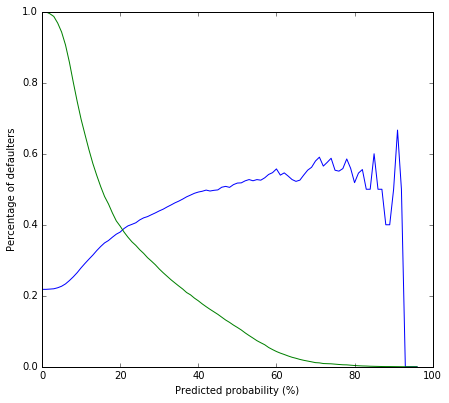

In [91]:
probabilities = model.predict_proba(x_test)
percentages = []
size = []
total = len(x_test)
try:
    for i in range(0,100):
        defaulters = len(np.where(y_test[np.where(probabilities[:,1] > i / 100)] == 1.0)[0])
        non_defaulters =  len(np.where(y_test[np.where(probabilities[:,1] > i / 100)] == 0)[0])
        percentages.append(defaulters / (defaulters + non_defaulters))
        size.append((defaulters + non_defaulters) / total) 
except ZeroDivisionError:
    np.array(percentages)
    print("Median: " + str(np.median(percentages)))
    print("Mean: " + str(np.mean(percentages)))
    percentages[25]

    plt.figure(1,(7,14))
    plt.subplot(211)
    plt.plot(percentages)
    plt.plot(size)
    plt.xlabel("Predicted probability (%)")
    plt.ylabel("Percentage of defaulters")


Median: 0.724425359939
Mean: 0.678397996871


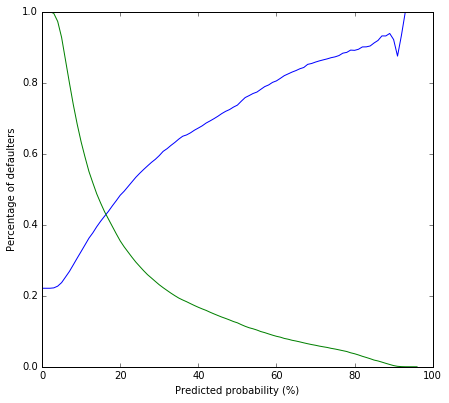

In [82]:
probabilities = model_all.predict_proba(all_data)
percentages = []
size = []
total = len(all_data)
try:
    for i in range(0,100):
        defaulters = len(np.where(all_labels[np.where(probabilities[:,1] > i / 100)] == 1.0)[0])
        non_defaulters =  len(np.where(all_labels[np.where(probabilities[:,1] > i / 100)] == 0)[0])
        percentages.append(defaulters / (defaulters + non_defaulters))
        size.append((defaulters + non_defaulters) / total) 
except ZeroDivisionError:
    np.array(percentages)
    print("Median: " + str(np.median(percentages)))
    print("Mean: " + str(np.mean(percentages)))
    percentages[25]

    plt.figure(1,(7,14))
    plt.subplot(211)
    plt.plot(percentages)
    plt.plot(size)
    plt.xlabel("Predicted probability (%)")
    plt.ylabel("Percentage of defaulters")

In [84]:
model.feature_importances_

array([ 0.1207774 ,  0.01834035,  0.03206361,  0.03770516,  0.05498848,
        0.30607587,  0.43004913])

In [ ]:
model_all.feature_importances_

In [136]:
clf = GBC(n_estimators=100)

In [137]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [148]:
param_grid = {"max_depth": [2, 3, 4, None],
              "max_features": [3, 4, 5, 6, 7],
              "min_samples_split": [2, 3, 10, 15, 30],
              "min_samples_leaf": [1, 3, 10, 20, 30]}

In [150]:
grid_search = GridSearchCV(clf, param_grid=param_grid, n_jobs = 4)
start = time()
grid_search.fit(x_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 2194.04 seconds for 500 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.788 (std: 0.002)
Parameters: {'max_features': 4, 'min_samples_split': 15, 'max_depth': 4, 'min_samples_leaf': 3}

Model with rank: 2
Mean validation score: 0.787 (std: 0.001)
Parameters: {'max_features': 6, 'min_samples_split': 30, 'max_depth': 4, 'min_samples_leaf': 10}

Model with rank: 3
Mean validation score: 0.787 (std: 0.002)
Parameters: {'max_features': 3, 'min_samples_split': 15, 'max_depth': 4, 'min_samples_leaf': 1}

